# The Future of Basketball Players

## Set up Environment

In [1]:
!python -c "import pandas as pd; print(pd.__version__)"

1.2.1


In [2]:
!pip show scipy

Name: scipy
Version: 1.6.0
Summary: SciPy: Scientific Library for Python
Home-page: https://www.scipy.org
Author: None
Author-email: None
License: BSD
Location: c:\programdata\anaconda3\lib\site-packages
Requires: numpy
Required-by: -, -cikit-learn, xgboost, statsmodels, seaborn, scikit-learn, pmdarima, phik, pandas-profiling, missingno, Keras, imbalanced-learn, ImageHash, hyperopt, hpsklearn


In [3]:
# Import modules
import os
import sys
import subprocess
import zipfile
import sklearn
import pandas as pd
import numpy as np
from joblib import dump, load
from pprint import pprint
from pandas_profiling import ProfileReport
from IPython.display import IFrame
import random
from pytictoc import TicToc

In [4]:
# Ensure the directory is correct... every time.
for i in range(5):
    if not os.getcwd().lower() == subprocess.run("git rev-parse --show-toplevel", stdout=subprocess.PIPE).stdout.decode("utf-8").replace("/","\\").strip().lower():
        os.chdir(".."),
    else:
        break

In [5]:
# Set up sys path environment
if not os.path.abspath(".") in sys.path:
    sys.path.append(os.path.abspath("."))
else:
    sys.path.remove(os.path.abspath("."))
    sys.path.append(os.path.abspath("."))

### Custom Globals

In [6]:
### Classes ###

class TicToc(TicToc):
    """Extend the original TicToc class"""
    def toc(self, msg='Elapsed time:', restart=False):
        from timeit import default_timer
        from datetime import timedelta
        self.end     = default_timer()
        self.elapsed = self.end - self.start
        print('%s %s' % (msg, timedelta(seconds=round(self.elapsed))))
        if restart:
            self.start = default_timer()

# Instantiate Global Classes
t = TicToc()

In [7]:
### Functions ###


## Get Data

In [8]:
# Check & Create directories
for dir in ["./data/processed/Chris", "./models/Chris"]:
    if not os.path.exists(dir): os.mkdir(dir)

In [9]:
# Use bash to get data from kaggle
!kaggle competitions files -c uts-advdsi-nba-career-prediction
!kaggle competitions download -c uts-advdsi-nba-career-prediction --path ./data/raw --force --quiet

# Unzip the data
with zipfile.ZipFile("./data/raw/uts-advdsi-nba-career-prediction.zip", "r") as z:
    z.extractall("./data/raw")

# Delete the zip file
if os.path.exists("./data/raw/uts-advdsi-nba-career-prediction.zip"):
    os.remove("./data/raw/uts-advdsi-nba-career-prediction.zip")

name                    size  creationDate         
---------------------  -----  -------------------  
test.csv               323KB  2021-01-30 23:13:35  
train.csv              701KB  2021-01-30 23:13:35  
sample_submission.csv   40KB  2021-01-30 23:13:35  


In [10]:
# Turn off table squishing
pd.options.display.max_columns = None

# Import data
data = pd.read_csv("./data/raw/train.csv")

# Check data
# print(data.columns)
display(data)

,Id_old,Id,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,TARGET_5Yrs
0,10556,3799,80,24.3,7.8,3.0,6.4,45.7,0.1,0.3,22.6,2.0,2.9,72.1,2.2,2.0,3.8,3.2,1.1,0.2,1.6,1
1,5342,3800,75,21.8,10.5,4.2,7.9,55.1,-0.3,-1.0,34.9,2.4,3.6,67.8,3.6,3.7,6.6,0.7,0.5,0.6,1.4,1
2,5716,3801,85,19.1,4.5,1.9,4.5,42.8,0.4,1.2,34.3,0.4,0.6,75.7,0.6,1.8,2.4,0.8,0.4,0.2,0.6,1
3,13790,3802,63,19.1,8.2,3.5,6.7,52.5,0.3,0.8,23.7,0.9,1.5,66.9,0.8,2.0,3.0,1.8,0.4,0.1,1.9,1
4,5470,3803,63,17.8,3.7,1.7,3.4,50.8,0.5,1.4,13.7,0.2,0.5,54.0,2.4,2.7,4.9,0.4,0.4,0.6,0.7,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,2996,11794,32,9.2,1.8,0.7,1.8,40.3,-0.1,-0.2,23.1,0.4,0.6,65.7,0.3,1.8,1.9,0.5,0.3,0.2,0.4,1
7996,11679,11795,54,6.0,1.8,0.7,1.4,48.7,0.1,0.1,3.1,0.2,0.4,70.1,1.0,1.1,2.0,0.1,0.0,0.3,0.3,1
7997,5537,11796,85,28.2,10.7,4.0,9.0,45.1,0.2,0.6,23.6,2.8,3.9,69.7,1.0,2.1,3.1,3.4,1.2,0.2,1.8,1
7998,1292,11797,39,7.7,2.5,1.0,2.3,40.1,-0.3,-0.5,13.3,0.6,0.7,74.3,0.4,0.6,0.9,0.2,0.3,0.3,0.5,1


In [11]:
# Fix column names
print(data.columns)
data.columns = data.columns.str.replace(' ', '_')
print(data.columns)

# Save training data again
data.to_csv("./data/raw/train.csv", index=False)

# Apply same logix to test data
test = pd.read_csv("./data/raw/test.csv")
test.columns = test.columns.str.replace(' ', '_')
test.to_csv("./data/raw/test.csv", index=False)

Index(['Id_old', 'Id', 'GP', 'MIN', 'PTS', 'FGM', 'FGA', 'FG%', '3P Made',
       '3PA', '3P%', 'FTM', 'FTA', 'FT%', 'OREB', 'DREB', 'REB', 'AST', 'STL',
       'BLK', 'TOV', 'TARGET_5Yrs'],
      dtype='object')
Index(['Id_old', 'Id', 'GP', 'MIN', 'PTS', 'FGM', 'FGA', 'FG%', '3P_Made',
       '3PA', '3P%', 'FTM', 'FTA', 'FT%', 'OREB', 'DREB', 'REB', 'AST', 'STL',
       'BLK', 'TOV', 'TARGET_5Yrs'],
      dtype='object')


## Check Data

### Data Dictionary

In [43]:
# Direct copy & paste from:
# https://www.kaggle.com/c/uts-advdsi-nba-career-prediction/data

DataDict = \
    { "Id_old": "Previous Player Identifier"
    , "Id": "Player Identifier"
    , "GP": "Games Played"
    , "MIN": "Minutes Played"
    , "PTS": "Points Per Game"
    , "FGM": "Field Goals Made"
    , "FGA": "Field Goals Attempts"
    , "FG%": "Field Goals Percent"
    , "3P_Made": "3-Points Made"
    , "3PA": "3-Points Attempts"
    , "3P%": "3-Points Percent"
    , "FTM": "Free Throw Made"
    , "FTA": "Free Throw Attempts"
    , "FT%": "Free Throw Percent"
    , "OREB": "Offensive Rebounds"
    , "DREB": "Defensive Rebounds"
    , "REB": "Rebounds"
    , "AST": "Assists"
    , "STL": "Steals"
    , "BLK": "Blocks"
    , "TOV": "Turnovers"
    , "TARGET_5Yrs": "Outcome: 1 if career length >= 5 years, 0 otherwise"
    }

### Data Exploration

In [13]:
# Prevent the need to re-run
if os.path.exists("InitialReport.html"):
    IFrame(src="InitialReport.html", width="100%", height=600)
else:
    # Create profile report
    profile = ProfileReport(data, title="Profile Report")
    # Export
    profile.to_file("InitialReport.html")
    # View
    profile

## Experimentation

### Data Manipulation

Steps:

1. Drop the `ID` column
1. Pop the `target` column
1. Scale the features
1. Split in to train/test

In [14]:
# Drop ID
data = data.drop(['Id','Id_old'], axis=1)

# Pop targ
feat = data.iloc[:,:-1].to_numpy()
targ = data.iloc[:,-1].to_numpy()

# Scale feat
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
feat = scaler.fit_transform(feat)

# Tran/Test split
# Make sure you stratify the results based on the target variable
from sklearn.model_selection import train_test_split
feat_trn, feat_val, targ_trn, targ_val = train_test_split(feat, targ, stratify=targ, test_size=0.3, random_state=123)

In [196]:
# for _ in [data, feat, targ, feat_trn, targ_trn, feat_val, targ_val]:
#     print(type(_))
#     print(_.shape)

print(data.columns)
cols = [col for col in data.columns if '%' in col]
print(cols)

Index(['GP', 'MIN', 'PTS', 'FGM', 'FGA', 'FG%', '3P_Made', '3PA', '3P%', 'FTM',
       'FTA', 'FT%', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV',
       'TARGET_5Yrs'],
      dtype='object')
['FG%', '3P%', 'FT%']


In [15]:
# Dump your objects
dump(data, "./data/processed/Chris/data.joblib")
dump(feat, "./data/processed/Chris/feat.joblib")
dump(targ, "./data/processed/Chris/targ.joblib")
dump(feat_trn, "./data/processed/Chris/feat_trn.joblib")
dump(feat_val, "./data/processed/Chris/feat_val.joblib")
dump(targ_trn, "./data/processed/Chris/targ_trn.joblib")
dump(targ_val, "./data/processed/Chris/targ_val.joblib")
dump(scaler, "./models/Chris/scaler.joblib")

['./models/Chris/scaler.joblib']

### Set up Experiment Space

In [16]:
# Set DF for score dumps
pred_scor = pd.DataFrame(
    { "name": []
    , "when": []
    , "auc": []
    , "sens": []
    , "spec": []
    , "f1": []
    }
)

In [185]:
def get_auc(targ:np.real, pred_prob:np.real):

    # Imports
    import numpy as np
    from sklearn.metrics import roc_curve, auc

    # Assertions
    assert np.all(np.isreal(targ))
    assert np.all(np.isreal(pred_prob))

    # Correct
    if len(pred_prob.shape)>1:
        pred_prob = pred_prob[:,1]

    # Compute
    fpr, tpr, thresholds = roc_curve(targ, pred_prob, pos_label=1)
    roc_auc = auc(fpr, tpr)

    # Return
    return roc_auc

def plot_roc_curve(targ:np.real, pred_prob:np.real):

    # Imports
    import numpy as np
    from sklearn.metrics import roc_curve, auc
    from matplotlib import pyplot as plt

    # Assertions
    assert np.all(np.isreal(targ))
    assert np.all(np.isreal(pred_prob))

    # Generate data
    fpr, tpr, thresholds = roc_curve(targ, pred_prob, pos_label=1)
    roc_auc = auc(fpr, tpr)

    # Generate plot
    plt.figure()
    lw=2
    plt.plot(fpr, tpr, color="darkorange", lw=lw, label="ROC (AUC={:.3f}".format(roc_auc))
    plt.plot([0,1], [0,1], color="navy", lw=lw, linestyle="--")
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristics")
    plt.legend(loc="lower right")
    plt.show

    # Return
    return None

def save_reg_perf \
    ( targ:np.real
    , pred:np.real
    , pred_prob:np.real
    , name:str=None
    , df_metrics:pd.DataFrame=None
    , overwrite:bool=True
    , print_all:bool=True
    , print_matrix:bool=True
    , print_plot:bool=True
    , print_dataframe:bool=True
    ):
    """
    Save model metrics to a dataframe.

    Args:
        targ (np.real): The actual values. Can be scalar or arrya, but must be Real numbers.
        pred (np.real): The prediction values. Can be scalar or array, but must be Real numbers. Must provide _either_ `pred` or `pred_probs`. Defaults to None.
        pred_prob (np.real): The prediction probability values. Can be scalar or array, but must be Real numbers. Must provide _either_ `pred` or `pred_probs`. Defaults to None.
        name (str, optional): The name of the data being calculated. If not given, will default to 'None'. Defaults to None.
        df_metrics (pd.DataFrame, optional): The data frame to be updated to contain the data. If not given, will update the `pred_scor` dataframe from the global scope. Defaults to None.
        overwrite (bool, optional): Whether or not to overwrite the data in the dataframe. In SQL-speak: True=UPDATE, False=INSERT. Defaults to True.
        print (bool, optional): Wheather or not to turn off all printing. Defaults to True.
        print_matrix (bool, optional): Whether or not to print the confusion matrix. Defaults to True.
        print_plot (bool, optional): Whether or not to print the ROC plot. Defaults to True.
        print_dataframe (bool, optional): Whether or not to print the final updated dataframe. Defaults to True.

    Raises:
        Assertions: Each parameter will be asserted to the proper type and attribute.

    Returns:
        pd.DataFrame: The updated dataframe.
    """    
    
    # Imports
    import numpy as np
    import pandas as pd
    from sklearn.metrics import confusion_matrix as conf
    from sklearn.metrics import roc_auc_score as roc_auc
    from sklearn.metrics import f1_score as f1
    from sklearn.metrics import roc_curve, auc

    # Assertions
    assert np.all(np.isreal(targ))
    assert np.all(np.isreal(pred))
    assert np.all(np.isreal(pred_prob))
    if not name==None:
        assert np.isscalar(name)
        assert isinstance(name, str)
    if not df_metrics==None:
        assert isinstance(df_metrics, pd.DataFrame)
        assert df_metrics.columns == ["name","when","auc","sens","spec","f1"]
    for parameter in [overwrite, print_matrix, print_plot, print_dataframe]:
        assert isinstance(parameter, bool)

    # Ensure we're using the global object here
    global pred_scor

    # If you want to use another dataframe, go right ahead. Else, just keep it simple.
    if df_metrics==None: df = pred_scor
    else: df = df_metrics
    
    # Best to define name, but if blank then make None
    if name==None: name=="None"

    # Fix dimensions of the prob part
    if len(pred_prob.shape)>1:
        pred_prob = pred_prob[:,1]

    # Perform calculations
    val_now = pd.Timestamp.now().strftime('%d/%b %H:%M')
    val_auc = round(roc_auc(targ,pred_prob), 5)
    fpr, tpr, thre = roc_curve(targ, pred_prob, pos_label=1)
    tn, fp, fn, tp = conf(targ,pred).ravel()
    val_sens = round(tp/(tp+fn), 5)
    val_spec = round(tn/(tn+fp), 5)
    val_f1 = round(f1(targ,pred), 5)

    # Two different methods of updating the table. In SQL-Speak this is the difference between INSERT and UPDATE
    if overwrite and name in df["name"].to_numpy():
        df.loc[df["name"] == name, ["when"]] = val_now
        df.loc[df["name"] == name, ["auc"]] = val_auc
        df.loc[df["name"] == name, ["sens"]] = val_sens
        df.loc[df["name"] == name, ["spec"]] = val_spec
        df.loc[df["name"] == name, ["f1"]] = val_f1
    else:
        new = pd.DataFrame \
            (
                { "name": [name]
                , "when": [val_now]
                , "auc": [val_auc]
                , "sens": [val_sens]
                , "spec": [val_spec]
                , "f1": [val_f1]
                }
            )
        df = df.append(new)

    # Fix Pandas indexes
    df.reset_index(drop=True, inplace=True)

    # Assign back to the global scope
    pred_scor = df

    # Print if needed
    if print_all:
        if print_matrix:
            display \
                ( pd.DataFrame \
                    ( conf(targ,pred)
                    , columns=pd.MultiIndex.from_tuples([("pred",0),("pred",1)])
                    , index=pd.MultiIndex.from_tuples([("targ",0),("targ",1)])
                    )
                )
        if print_plot:
            plot_roc_curve(targ, pred_prob)
        if print_dataframe:
            display(df)

    # Return
    return df

### Baseline

pred      
          0     1
targ 0    0  1331
     1    0  6669

,name,when,auc,sens,spec,f1
0,Raw baseline,13/Feb 10:40,0.5,1.0,0.0,0.90926


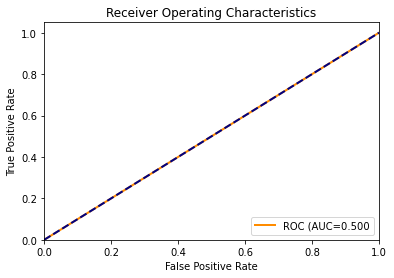

In [18]:
from statistics import mode
from src.utils.misc import get_list_proportions

# Generate actuals
act = np.array(data['TARGET_5Yrs'])
# print("Actual proportions: {}".format(get_list_proportions(act)))

# Generate baseline, based on random re-sampling with the same proportions
# random.seed(123)
# bas = random.choices([1,0], weights=list(get_list_proportions(act)), k=len(data))
bas = np.full(act.shape, mode(act))

# Check objects
# from src.utils.objects import check_object
# check_object(act, "act", _head_size=20)
# check_object(bas, "bas", _head_size=20)

# Check performance
save_reg_perf(act, bas, bas, "Raw baseline", print_matrix=True, print_plot=True, print_dataframe=False)

### Attempt #1: ElasticNet

pred      
          0     1
targ 0   22   377
     1   13  1988

,name,when,auc,sens,spec,f1
0,Raw baseline,13/Feb 10:40,0.50000,1.0000,0.00000,0.90926
1,LogisticRegression - Defaults,13/Feb 10:40,0.70163,0.9935,0.05514,0.91067


['./models/Chris/01_LogisticRegression_Defaults.joblib']

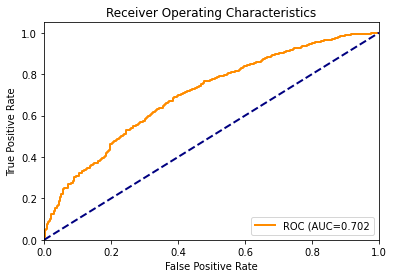

In [19]:
# Import model
from sklearn.linear_model import LogisticRegression

# Instantiate
reg = LogisticRegression(random_state=123)

# Train
reg.fit(feat_trn, targ_trn)

# Predict on training data
pred_trn = reg.predict(feat_trn)

# Predict on validation data
pred_val = reg.predict(feat_val)
pred_val_prob = reg.predict_proba(feat_val)

# save_reg_perf(pred_trn, targ_trn, "LogisticRegression - Defaults - within bag", print_all=False)
save_reg_perf(targ_val, pred_val, pred_val_prob, "LogisticRegression - Defaults")

# Backup
dump(reg, "./models/Chris/01_LogisticRegression_Defaults.joblib")

In [20]:
# Marginally better... barely worth it...

### Attempt #2: ElasticNetCV

pred      
          0     1
targ 0   50  1281
     1   38  6631

,name,when,auc,sens,spec,f1
0,Raw baseline,13/Feb 10:40,0.50000,1.0000,0.00000,0.90926
1,LogisticRegression - Defaults,13/Feb 10:40,0.70163,0.9935,0.05514,0.91067
2,LogisticRegressionCV - Defaults,13/Feb 10:40,0.70830,0.9943,0.03757,0.90954


['./models/Chris/02_LogisticRegressionCV_Defaults.joblib']

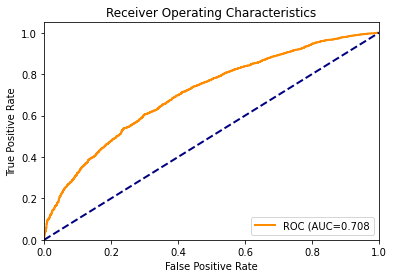

In [21]:
# Import model
from sklearn.linear_model import LogisticRegressionCV

# Instantiate
reg = LogisticRegressionCV(random_state=123)

# Train
reg.fit(feat, targ)

# Predict on validation data
pred = reg.predict(feat)
pred_prob = reg.predict_proba(feat)

# Check performance
save_reg_perf(targ, pred, pred_prob, "LogisticRegressionCV - Defaults")

# Backup
dump(reg, "./models/Chris/02_LogisticRegressionCV_Defaults.joblib")

In [22]:
# Slignt improvement. But nothing substantive yet.

### Attempt #3: RidgeClassifier

pred      
          0     1
targ 0    2   397
     1    3  1998

,name,when,auc,sens,spec,f1
0,Raw baseline,13/Feb 10:40,0.50000,1.0000,0.00000,0.90926
1,LogisticRegression - Defaults,13/Feb 10:40,0.70163,0.9935,0.05514,0.91067
2,LogisticRegressionCV - Defaults,13/Feb 10:40,0.70830,0.9943,0.03757,0.90954
3,RidgeClassifier - Defaults,13/Feb 10:40,0.69848,0.9985,0.00501,0.90901


['./models/Chris/03_RidgeClassifier_Defaults.joblib']

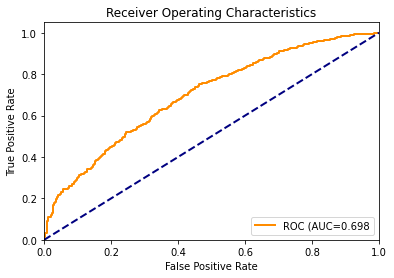

In [23]:
# Import model
from sklearn.linear_model import RidgeClassifier

# Instantiate
reg = RidgeClassifier(random_state=123)

# Train
reg.fit(feat_trn, targ_trn)

# Predict on training data
pred_trn = reg.predict(feat_trn)

# Predict on validation data
pred_val = reg.predict(feat_val)
pred_val_prob = reg.decision_function(feat_val)

# Check performance
# save_reg_perf(pred_trn, targ_trn, "RidgeClassifier - Defaults - within bag", print_all=False)
save_reg_perf(targ_val, pred_val, pred_val_prob, "RidgeClassifier - Defaults")

# Backup
dump(reg, "./models/Chris/03_RidgeClassifier_Defaults.joblib")

In [24]:
#

### Attempt #4: RidgeClassifierCV

pred      
          0     1
targ 0    5  1326
     1    2  6667

,name,when,auc,sens,spec,f1
0,Raw baseline,13/Feb 10:40,0.50000,1.0000,0.00000,0.90926
1,LogisticRegression - Defaults,13/Feb 10:40,0.70163,0.9935,0.05514,0.91067
2,LogisticRegressionCV - Defaults,13/Feb 10:40,0.70830,0.9943,0.03757,0.90954
3,RidgeClassifier - Defaults,13/Feb 10:40,0.69848,0.9985,0.00501,0.90901
4,RidgeClassifierCV - Defaults,13/Feb 10:40,0.70651,0.9997,0.00376,0.90943


['./models/Chris/04_RidgeClassifierCV_Defaults.joblib']

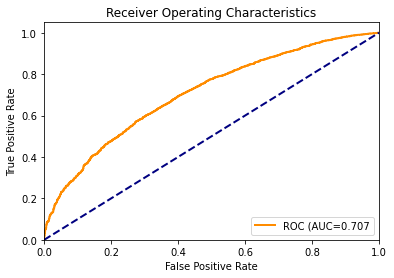

In [25]:
# Import model
from sklearn.linear_model import RidgeClassifierCV

# Instantiate
reg = RidgeClassifierCV()

# Train
reg.fit(feat, targ)

# Predict on validation data
pred = reg.predict(feat)
pred_prob = reg.decision_function(feat)

# Check performance
save_reg_perf(targ, pred, pred_prob, "RidgeClassifierCV - Defaults")

# Backup
dump(reg, "./models/Chris/04_RidgeClassifierCV_Defaults.joblib")

### Attempt #5: SGDClassifier

pred      
          0     1
targ 0   10   389
     1    7  1994

,name,when,auc,sens,spec,f1
0,Raw baseline,13/Feb 10:40,0.50000,1.0000,0.00000,0.90926
1,LogisticRegression - Defaults,13/Feb 10:40,0.70163,0.9935,0.05514,0.91067
2,LogisticRegressionCV - Defaults,13/Feb 10:40,0.70830,0.9943,0.03757,0.90954
3,RidgeClassifier - Defaults,13/Feb 10:40,0.69848,0.9985,0.00501,0.90901
4,RidgeClassifierCV - Defaults,13/Feb 10:40,0.70651,0.9997,0.00376,0.90943
5,SGDClassifier - Defaults,13/Feb 10:40,0.68176,0.9965,0.02506,0.90967


['./models/Chris/05_SGDClassifier_Defaults.joblib']

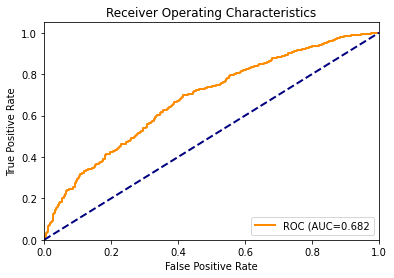

In [26]:
# Import model
from sklearn.linear_model import SGDClassifier

# Instantiate
reg = SGDClassifier(random_state=123)

# Train
reg.fit(feat_trn, targ_trn)

# Predict on training data
pred_trn = reg.predict(feat_trn)

# Predict on validation data
pred_val = reg.predict(feat_val)
pred_val_prob = reg.decision_function(feat_val)

# Check performance
# save_reg_perf(pred_trn, targ_trn, "SGDClassifier - Defaults - within bag", print_all=False)
save_reg_perf(targ_val, pred_val, pred_val_prob, "SGDClassifier - Defaults")

# Backup
dump(reg, "./models/Chris/05_SGDClassifier_Defaults.joblib")

### Attempt #6: RandomForest

Elapsed time: 0:00:01


pred      
          0     1
targ 0   31   368
     1   47  1954

,name,when,auc,sens,spec,f1
0,Raw baseline,13/Feb 10:40,0.50000,1.00000,0.00000,0.90926
1,LogisticRegression - Defaults,13/Feb 10:40,0.70163,0.99350,0.05514,0.91067
2,LogisticRegressionCV - Defaults,13/Feb 10:40,0.70830,0.99430,0.03757,0.90954
3,RidgeClassifier - Defaults,13/Feb 10:40,0.69848,0.99850,0.00501,0.90901
4,RidgeClassifierCV - Defaults,13/Feb 10:40,0.70651,0.99970,0.00376,0.90943
5,SGDClassifier - Defaults,13/Feb 10:40,0.68176,0.99650,0.02506,0.90967
6,RandomForest - Defaults,13/Feb 10:40,0.68110,0.97651,0.07769,0.90400


['./models/Chris/06_RandomForest_Defaults.joblib']

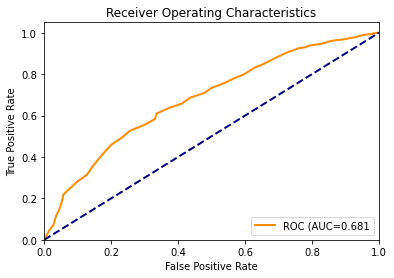

In [27]:
# Import model
from sklearn.ensemble import RandomForestClassifier
from src.utils.misc import get_list_proportions

# Instantiate
reg = RandomForestClassifier \
    ( n_jobs=4
    , random_state=123
    , class_weight=get_list_proportions(targ))

# Train
t.tic()
reg.fit(feat_trn, targ_trn)
t.toc()

# Predict on training data
pred_trn = reg.predict(feat_trn)

# Predict on validation data
pred_val = reg.predict(feat_val)
pred_val_prob = reg.predict_proba(feat_val)

# Check performance
# save_reg_perf(pred_trn, targ_trn, "RandomForest - Defaults - within bag", print_all=False)
save_reg_perf(targ_val, pred_val, pred_val_prob, "RandomForest - Defaults")

# Backup
dump(reg, "./models/Chris/06_RandomForest_Defaults.joblib")

In [28]:
# **NOW** We're cookin with Gas!

### Attempt #7: Bagging

pred      
          0     1
targ 0   56   343
     1  141  1860

,name,when,auc,sens,spec,f1
0,Raw baseline,13/Feb 10:40,0.50000,1.00000,0.00000,0.90926
1,LogisticRegression - Defaults,13/Feb 10:40,0.70163,0.99350,0.05514,0.91067
2,LogisticRegressionCV - Defaults,13/Feb 10:40,0.70830,0.99430,0.03757,0.90954
3,RidgeClassifier - Defaults,13/Feb 10:40,0.69848,0.99850,0.00501,0.90901
4,RidgeClassifierCV - Defaults,13/Feb 10:40,0.70651,0.99970,0.00376,0.90943
5,SGDClassifier - Defaults,13/Feb 10:40,0.68176,0.99650,0.02506,0.90967
6,RandomForest - Defaults,13/Feb 10:40,0.68110,0.97651,0.07769,0.90400
7,Bagging - Defaults,13/Feb 10:40,0.63222,0.92954,0.14035,0.88487


['./models/Chris/07_Bagging_Defaults.joblib']

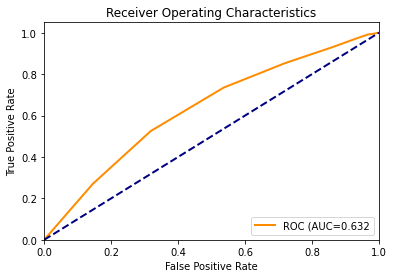

In [29]:
# Import model
from sklearn.ensemble import BaggingClassifier

# Instantiate
reg = BaggingClassifier(random_state=123)

# Train
reg.fit(feat_trn, targ_trn)

# Predict on training data
pred_trn = reg.predict(feat_trn)

# Predict on validation data
pred_val = reg.predict(feat_val)
pred_val_prob = reg.predict_proba(feat_val)

# Check performance
# save_reg_perf(pred_trn, targ_trn, "Bagging - Defaults - within bag", print_all=False)
save_reg_perf(targ_val, pred_val, pred_val_prob, "Bagging - Defaults")

# Backup
dump(reg, "./models/Chris/07_Bagging_Defaults.joblib")

### Attempt #8: Gradient Boosting

pred      
          0     1
targ 0   21   378
     1   23  1978

,name,when,auc,sens,spec,f1
0,Raw baseline,13/Feb 10:40,0.50000,1.00000,0.00000,0.90926
1,LogisticRegression - Defaults,13/Feb 10:40,0.70163,0.99350,0.05514,0.91067
2,LogisticRegressionCV - Defaults,13/Feb 10:40,0.70830,0.99430,0.03757,0.90954
3,RidgeClassifier - Defaults,13/Feb 10:40,0.69848,0.99850,0.00501,0.90901
4,RidgeClassifierCV - Defaults,13/Feb 10:40,0.70651,0.99970,0.00376,0.90943
5,SGDClassifier - Defaults,13/Feb 10:40,0.68176,0.99650,0.02506,0.90967
6,RandomForest - Defaults,13/Feb 10:40,0.68110,0.97651,0.07769,0.90400
7,Bagging - Defaults,13/Feb 10:40,0.63222,0.92954,0.14035,0.88487
8,Boosting - Defaults,13/Feb 10:40,0.69825,0.98851,0.05263,0.90796


['./models/Chris/08_Boosting_Defaults.joblib']

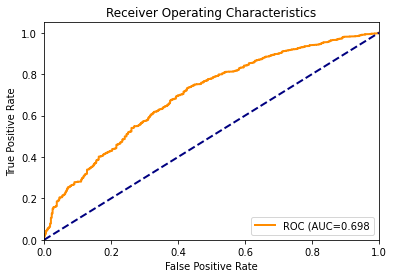

In [30]:
# Import model
from sklearn.ensemble import GradientBoostingClassifier

# Instantiate
reg = GradientBoostingClassifier(random_state=123)

# Train
reg.fit(feat_trn, targ_trn)

# Predict on training data
pred_trn = reg.predict(feat_trn)

# Predict on validation data
pred_val = reg.predict(feat_val)
pred_val_prob = reg.predict_proba(feat_val)

# Check performance
# save_reg_perf(pred_trn, targ_trn, "Boosting - Defaults - within bag", print_all=False)
save_reg_perf(targ_val, pred_val, pred_val_prob, "Boosting - Defaults")

# Backup
dump(reg, "./models/Chris/08_Boosting_Defaults.joblib")

In [31]:
# Slightly better than the ElasticNet models, not as good as the RandomForest

### Attempt #9: AdaBoost

pred      
          0     1
targ 0    9   390
     1   16  1985

,name,when,auc,sens,spec,f1
0,Raw baseline,13/Feb 10:40,0.50000,1.00000,0.00000,0.90926
1,LogisticRegression - Defaults,13/Feb 10:40,0.70163,0.99350,0.05514,0.91067
2,LogisticRegressionCV - Defaults,13/Feb 10:40,0.70830,0.99430,0.03757,0.90954
3,RidgeClassifier - Defaults,13/Feb 10:40,0.69848,0.99850,0.00501,0.90901
4,RidgeClassifierCV - Defaults,13/Feb 10:40,0.70651,0.99970,0.00376,0.90943
5,SGDClassifier - Defaults,13/Feb 10:40,0.68176,0.99650,0.02506,0.90967
6,RandomForest - Defaults,13/Feb 10:40,0.68110,0.97651,0.07769,0.90400
7,Bagging - Defaults,13/Feb 10:40,0.63222,0.92954,0.14035,0.88487
8,Boosting - Defaults,13/Feb 10:40,0.69825,0.98851,0.05263,0.90796
9,AdaBoost - Defaults,13/Feb 10:40,0.68613,0.99200,0.02256,0.90722


['./models/Chris/09_AdaBoost_Defaults.joblib']

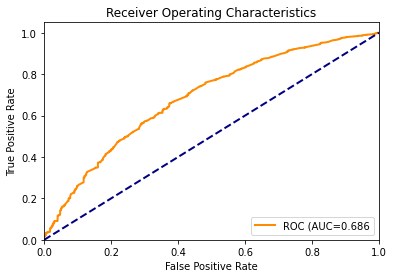

In [32]:
# Import model
from sklearn.ensemble import AdaBoostClassifier

# Instantiate
reg = AdaBoostClassifier(random_state=123)

# Train
reg.fit(feat_trn, targ_trn)

# Predict on training data
pred_trn = reg.predict(feat_trn)

# Predict on validation data
pred_val = reg.predict(feat_val)
pred_val_prob = reg.predict_proba(feat_val)

# Check performance
# save_reg_perf(pred_trn, targ_trn, "AdaBoost - Defaults - within bag", print_all=False)
save_reg_perf(targ_val, pred_val, pred_val_prob, "AdaBoost - Defaults")

# Backup
dump(reg, "./models/Chris/09_AdaBoost_Defaults.joblib")

### Attempt #10: LogisticRegression - RandomSearch

In [33]:
from src.utils.misc import get_list_proportions
print(get_list_proportions(targ))

{0: 0.166375, 1: 0.833625}


Elapsed time: 0:03:03
{'C': 0.19638852249110528, 'penalty': 'l2', 'solver': 'saga'}


pred      
          0     1
targ 0    1   398
     1    0  2001

,name,when,auc,sens,spec,f1
0,Raw baseline,13/Feb 10:40,0.50000,1.00000,0.00000,0.90926
1,LogisticRegression - Defaults,13/Feb 10:40,0.70163,0.99350,0.05514,0.91067
2,LogisticRegressionCV - Defaults,13/Feb 10:40,0.70830,0.99430,0.03757,0.90954
3,RidgeClassifier - Defaults,13/Feb 10:40,0.69848,0.99850,0.00501,0.90901
4,RidgeClassifierCV - Defaults,13/Feb 10:40,0.70651,0.99970,0.00376,0.90943
5,SGDClassifier - Defaults,13/Feb 10:40,0.68176,0.99650,0.02506,0.90967
6,RandomForest - Defaults,13/Feb 10:40,0.68110,0.97651,0.07769,0.90400
7,Bagging - Defaults,13/Feb 10:40,0.63222,0.92954,0.14035,0.88487
8,Boosting - Defaults,13/Feb 10:40,0.69825,0.98851,0.05263,0.90796
9,AdaBoost - Defaults,13/Feb 10:40,0.68613,0.99200,0.02256,0.90722


['./models/Chris/10_LogisticRegression_RandomSearch.joblib']

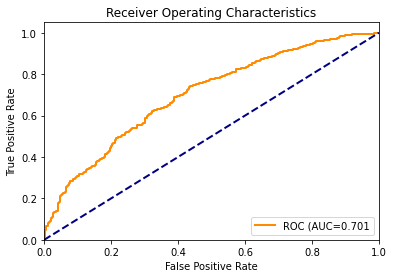

In [34]:
# Inspiration taken directly from SkLearn website:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html#sklearn.model_selection.RandomizedSearchCV

# Import model
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import make_scorer
from scipy.stats import uniform
from src.utils.misc import get_list_proportions

# Instantiate
reg = LogisticRegression \
    ( class_weight=get_list_proportions(targ)
    , random_state=123
    , max_iter=1000
    )

# Define hyperparameters
params = dict \
    ( penalty=['l1', 'l2', 'elasticnet']
    , C=uniform(loc=0, scale=4)
    , solver=['lbfgs', 'saga']
    )

# Re-instantiate
clf = RandomizedSearchCV \
    ( estimator=reg
    , param_distributions=params
    , n_iter=100
    , scoring={"auc": make_scorer(roc_auc_score, needs_proba=True)}
    , cv=5
    , refit="auc"
    , random_state=123
    , return_train_score=True
    )

# Search for results
t.tic()
res = clf.fit(feat_trn, targ_trn)
t.toc()

# Check best params
print(res.best_params_)
# display(pd.DataFrame(res.cv_results_))

# Retrain
cla = LogisticRegression \
    ( class_weight=get_list_proportions(targ)
    , random_state=123
    , max_iter=1000
    , C=res.best_params_["C"]
    , penalty=res.best_params_["penalty"]
    , solver=res.best_params_["solver"]
    )

# Train
cla.fit(feat_trn, targ_trn)

# Predict on validation data
pred_trn = cla.predict(feat_trn)
pred_prob_trn = cla.predict_proba(feat_trn)
pred_val = cla.predict(feat_val)
pred_prob_val = cla.predict_proba(feat_val)

# Check performance
save_reg_perf(targ_trn, pred_trn, pred_prob_trn, "LogisticRegression - RandomSearch - within bag", print_all=False)
save_reg_perf(targ_val, pred_val, pred_prob_val, "LogisticRegression - RandomSearch - out of bag")

# Backup
dump(reg, "./models/Chris/10_LogisticRegression_RandomSearch.joblib")

### Attempt 11: RandomForest - RandomSearch

In [140]:
from src.utils.misc import get_list_proportions
print(get_list_proportions(targ_trn))

{0: 0.16642857142857143, 1: 0.8335714285714285}


'2021-02-13 12:14:53'

Elapsed time: 0:11:17
{'max_depth': 5, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 348}


pred      
          0     1
targ 0    0   399
     1    0  2001

,name,when,auc,sens,spec,f1
0,Raw baseline,13/Feb 10:40,0.50000,1.00000,0.00000,0.90926
1,LogisticRegression - Defaults,13/Feb 10:40,0.70163,0.99350,0.05514,0.91067
2,LogisticRegressionCV - Defaults,13/Feb 10:40,0.70830,0.99430,0.03757,0.90954
3,RidgeClassifier - Defaults,13/Feb 10:40,0.69848,0.99850,0.00501,0.90901
4,RidgeClassifierCV - Defaults,13/Feb 10:40,0.70651,0.99970,0.00376,0.90943
5,SGDClassifier - Defaults,13/Feb 10:40,0.68176,0.99650,0.02506,0.90967
6,RandomForest - Defaults,13/Feb 10:40,0.68110,0.97651,0.07769,0.90400
7,Bagging - Defaults,13/Feb 10:40,0.63222,0.92954,0.14035,0.88487
8,Boosting - Defaults,13/Feb 10:40,0.69825,0.98851,0.05263,0.90796
9,AdaBoost - Defaults,13/Feb 10:40,0.68613,0.99200,0.02256,0.90722


['./models/Chris/11_RandomForest_RandomSearch.joblib']

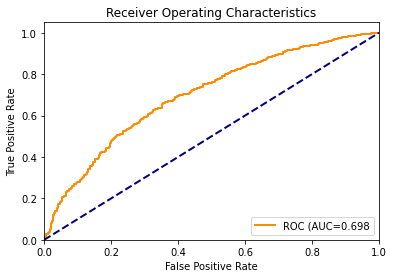

In [36]:
# Inspiration taken directly from SkLearn website:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html#sklearn.model_selection.RandomizedSearchCV

# Import model
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from scipy.stats import randint
from src.utils.misc import get_list_proportions

# Instantiate
reg = RandomForestClassifier \
    ( n_jobs=4
    , random_state=123
    , class_weight=get_list_proportions(targ)
    )

# Define hyperparameters
params = dict \
    ( n_estimators=randint(low=100, high=500)
    , max_depth=[5,10,20,50,75,100,200]
    , min_samples_split=randint(low=1, high=10)
    , min_samples_leaf=randint(low=1, high=10)
    )

# Re-instantiate
clf = RandomizedSearchCV \
    ( estimator=reg
    , param_distributions=params
    , n_iter=100
    , scoring={"auc": make_scorer(roc_auc_score, needs_proba=True)}
    , cv=5
    , refit="auc"
    , random_state=123
    , return_train_score=True
    )

# Search for results
t.tic()
res = clf.fit(feat_trn, targ_trn)
t.toc()

# Check best params
print(res.best_params_)

# Retrain
cla = RandomForestClassifier \
    ( n_jobs=4
    , random_state=123
    , class_weight=get_list_proportions(targ)
    , n_estimators=res.best_params_["n_estimators"]
    , max_depth=res.best_params_["max_depth"]
    , min_samples_split=res.best_params_["min_samples_split"]
    , min_samples_leaf=res.best_params_["min_samples_leaf"]
    )
cla.fit(feat_trn, targ_trn)

# Predict
pred_trn = cla.predict(feat_trn)
pred_prob_trn = cla.predict_proba(feat_trn)
pred_val = cla.predict(feat_val)
pred_prob_val = cla.predict_proba(feat_val)

# Check performance
save_reg_perf(targ_trn, pred_trn, pred_prob_trn, "RandomForest - RandomSearch - within bag", print_all=False)
save_reg_perf(targ_val, pred_val, pred_prob_val, "RandomForest - RandomSearch - out of bag")

# Backup
dump(cla, "./models/Chris/11_RandomForest_RandomSearch.joblib")

In [37]:
cla = load("./models/Chris/11_RandomForest_RandomSearch.joblib")

### Attempt 12: Random Forest - RandomSearch - With Data Engineering

In [314]:
# Define reusable function for easy random searching
def easy_random_search \
    ( estimator
    , search_space:dict
    , feat_trn#=feat_trn
    , targ_trn#=targ_trn
    , feat_val#=feat_val
    , targ_val#=targ_val
    , n_iter=100
    , cv=5
    , random_state=123
    , check_best_params=True
    , dump_model=True
    , dump_location="./models/Chris/"
    , dump_name=datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    , print_all:bool=True
    , print_matrix:bool=True
    , print_plot:bool=True
    , print_dataframe:bool=True
    ):

    # Imports
    from sklearn.model_selection import RandomizedSearchCV
    from scipy.stats import uniform, randint
    from src.utils.misc import all_in
    import numpy as np
    from xgboost.sklearn import XGBModel

    # Assertions
    # assert "base_estimator" in estimator.__dict__.keys()          #<-- Ensure `estimator` is an instantiated class
    # assert "sklearn" in estimator.__module__.split(".")[0]        #<-- Ensure `estimator` is from the SkLearn family
    assert isinstance(search_space, dict)                         #<-- Ensure `serach_space` is a dict
    assert all_in(search_space.keys(), estimator.__dict__.keys()) #<-- Ensure all keys from `search_space` are valid params from `estimator`
    for param in [feat_trn, targ_trn, feat_val, targ_val]:        #<-- Loop params
        assert isinstance(param, np.ndarray)                      #<-- Ensure all data elements are numpy arrays
        assert np.all(np.isreal(param))                           #<-- Ensure all data elements are real numbers
    assert len(feat_trn)==len(targ_trn)                           #<-- Ensure the len of `feat_trn` is same as len of `targ_trn`
    assert len(feat_val)==len(targ_val)                           #<-- Ensure the len of `feat_val` is same as `targ_val`
    for param in [n_iter, cv, random_state]:                      #<-- Loop params
        assert isinstance(param, int)                             #<-- Ensure all scalar elements are integers
        assert param>0                                            #<-- Ensure all scalar elements are positive numbers
    assert isinstance(check_best_params, bool)                    #<-- Ensure `check_best_params` is boolean

    # Instantiate trainer
    clf = RandomizedSearchCV \
        ( estimator=estimator
        , param_distributions=search_space
        , n_iter=n_iter
        , scoring={"auc": make_scorer(roc_auc_score, needs_proba=True)}
        , cv=cv
        , refit="auc"
        , random_state=random_state
        , return_train_score=True
        )
    
    # Search for results
    t.tic()
    if isinstance(estimator, XGBModel):
        res = clf.fit(feat_trn, targ_trn, eval_metric="auc")
    else:
        res = clf.fit(feat_trn, targ_trn)
    t.toc()

    # Check best params
    if check_best_params:
        print("Best score: {}".format(res.best_score_))
        print("Best params: {}".format(res.best_params_))
    
    # Update params
    estimator = estimator.set_params(**res.best_params_)

    # Refit
    if isinstance(estimator, XGBModel):
        estimator.fit(feat_trn, targ_trn, eval_metric="auc")
    else:
        estimator.fit(feat_trn, targ_trn)

    # Predict
    pred_trn = estimator.predict(feat_trn)
    pred_prob_trn = estimator.predict_proba(feat_trn)
    pred_val = estimator.predict(feat_val)
    pred_prob_val = estimator.predict_proba(feat_val)

    # Check performance
    save_reg_perf \
        ( targ_trn
        , pred_trn
        , pred_prob_trn
        , dump_name
        , print_all=False
        , print_matrix=print_matrix
        , print_plot=print_plot
        , print_dataframe=print_dataframe
        )
    save_reg_perf \
        ( targ_val
        , pred_val
        , pred_prob_val
        , dump_name
        , print_all=print
        , print_matrix=print_matrix
        , print_plot=print_plot
        , print_dataframe=print_dataframe
        )

    # Backup
    if dump_model:
        dump(estimator, dump_location+dump_name+".joblib")

    # Return
    return estimator

Elapsed time: 0:01:48
{'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 411}


pred      
          0     1
targ 0    0   399
     1    0  2001

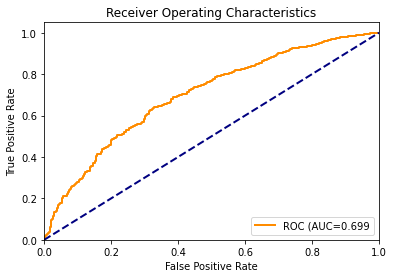

In [228]:
# Test the function

# Instantiate
cla = RandomForestClassifier \
    ( n_jobs=4
    , random_state=123
    , class_weight=get_list_proportions(targ)
    )

# Define hyperparameters
params = dict \
    ( n_estimators=randint(low=100, high=500)
    , max_depth=[5,10,20,50,75,100,200]
    , min_samples_split=randint(low=1, high=10)
    , min_samples_leaf=randint(low=1, high=10)
    )

cla = easy_random_search \
    ( estimator=cla
    , search_space=params
    , feat_trn=feat_trn
    , targ_trn=targ_trn
    , feat_val=feat_val
    , targ_val=targ_val
    , n_iter=20
    , cv=5
    , random_state=123
    , check_best_params=True
    , dump_model=False
    , print_all=True
    , print_dataframe=False
    )

In [208]:
# Check which variables are most important from RandomForest experiment
impt = {data.columns[indx]:valu for indx,valu in enumerate(cla.feature_importances_)}
impt = pd.DataFrame({"name":impt.keys(), "valu":impt.values()})
impt["desc"] = impt["name"].map(lambda name: DataDict[name])
impt = impt[["name","desc","valu"]]
display(impt.sort_values("valu", ascending=False))

,name,desc,valu
0,GP,Games Played,0.173664
2,PTS,Points Per Game,0.083526
5,FG%,Field Goals Percent,0.080149
1,MIN,Minutes Played,0.067340
3,FGM,Field Goals Made,0.058570
17,BLK,Blocks,0.056306
14,REB,Rebounds,0.054831
10,FTA,Free Throw Attempts,0.050934
9,FTM,Free Throw Made,0.047566
4,FGA,Field Goals Attempts,0.042608


In [213]:
# !THEORY! The columns with the percentages are throwing off the overall performance

# Inspect columns to see which ones to keep
display(impt)

# Define cols to use WITH percentages
pcts = [0,1,2,5,8,11,12,13,14,15,16,17,18]

# Define cols to use WITHOUT percentages
non_pcts = [0,1,2,3,4,6,7,9,10,12,13,14,15,16,17,18]

,name,desc,valu
0,GP,Games Played,0.173664
1,MIN,Minutes Played,0.067340
2,PTS,Points Per Game,0.083526
3,FGM,Field Goals Made,0.058570
4,FGA,Field Goals Attempts,0.042608
5,FG%,Field Goals Percent,0.080149
6,3P_Made,3-Points Made,0.019916
7,3PA,3-Points Attempts,0.036172
8,3P%,3-Points Percent,0.040366
9,FTM,Free Throw Made,0.047566


Elapsed time: 0:01:58
{'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 411}


pred      
          0     1
targ 0    0   399
     1    0  2001

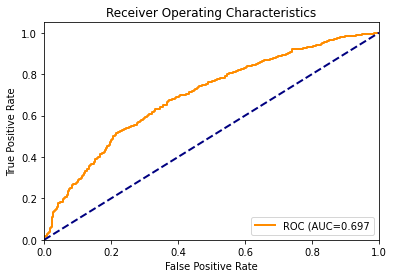

In [223]:
# Test random search ONLY USING averages
cla = easy_random_search \
    ( estimator=cla
    , search_space=params
    , feat_trn=feat_trn[:,pcts]
    , targ_trn=targ_trn
    , feat_val=feat_val[:,pcts]
    , targ_val=targ_val
    , n_iter=20
    , cv=5
    , random_state=123
    , check_best_params=True
    , dump_model=False
    , print_all=True
    , print_dataframe=False
    )

Elapsed time: 0:01:52
{'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 411}


pred      
          0     1
targ 0    0   399
     1    0  2001

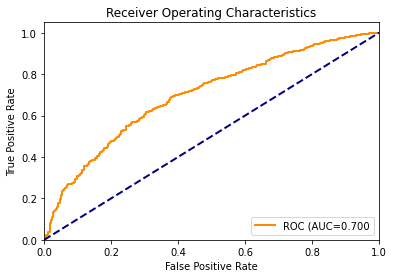

In [224]:
# Test random search WITHOUT USING averages
cla = easy_random_search \
    ( estimator=cla
    , search_space=params
    , feat_trn=feat_trn[:,non_pcts]
    , targ_trn=targ_trn
    , feat_val=feat_val[:,non_pcts]
    , targ_val=targ_val
    , n_iter=20
    , cv=5
    , random_state=123
    , check_best_params=True
    , dump_model=False
    , print_all=True
    , print_dataframe=False
    )

**Conclusion**

It didn't make any difference 😔

### Attempt 13: XGBoost - Default

Elapsed time: 0:00:00


pred      
          0     1
targ 0   46   353
     1   72  1929

,name,when,auc,sens,spec,f1
0,Raw baseline,13/Feb 10:40,0.50000,1.00000,0.00000,0.90926
1,LogisticRegression - Defaults,13/Feb 10:40,0.70163,0.99350,0.05514,0.91067
2,LogisticRegressionCV - Defaults,13/Feb 10:40,0.70830,0.99430,0.03757,0.90954
3,RidgeClassifier - Defaults,13/Feb 10:40,0.69848,0.99850,0.00501,0.90901
4,RidgeClassifierCV - Defaults,13/Feb 10:40,0.70651,0.99970,0.00376,0.90943
5,SGDClassifier - Defaults,13/Feb 10:40,0.68176,0.99650,0.02506,0.90967
6,RandomForest - Defaults,13/Feb 10:40,0.68110,0.97651,0.07769,0.90400
7,Bagging - Defaults,13/Feb 10:40,0.63222,0.92954,0.14035,0.88487
8,Boosting - Defaults,13/Feb 10:40,0.69825,0.98851,0.05263,0.90796
9,AdaBoost - Defaults,13/Feb 10:40,0.68613,0.99200,0.02256,0.90722


['./models/Chris/13_XGBoost_Default.joblib']

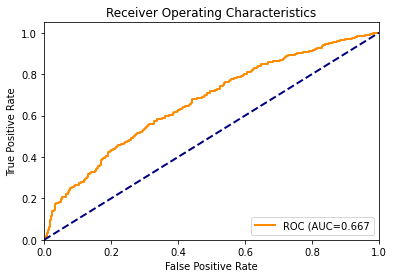

In [231]:
# Import
import xgboost as xgb

# Instantiate
cla = xgb.XGBClassifier \
    ( n_jobs=4
    , random_state=123
    )

# Train
t.tic()
cla.fit(feat_trn, targ_trn, eval_metric="auc")
t.toc()

# Predict
pred_trn = cla.predict(feat_trn)
pred_prob_trn = cla.predict_proba(feat_trn)
pred_val = cla.predict(feat_val)
pred_prob_val = cla.predict_proba(feat_val)

# Check performance
save_reg_perf(targ_trn, pred_trn, pred_prob_trn, "XGBoost - Default - within bag", print_all=False)
save_reg_perf(targ_val, pred_val, pred_prob_val, "XGBoost - Default - out of bag")

# Backup
dump(cla, "./models/Chris/13_XGBoost_Default.joblib")

### Attempt 14: XGBoost - Random Search

In [233]:
pprint(list(cla.__dict__.keys()))

['use_label_encoder',
 'n_estimators',
 'objective',
 'max_depth',
 'learning_rate',
 'verbosity',
 'booster',
 'tree_method',
 'gamma',
 'min_child_weight',
 'max_delta_step',
 'subsample',
 'colsample_bytree',
 'colsample_bylevel',
 'colsample_bynode',
 'reg_alpha',
 'reg_lambda',
 'scale_pos_weight',
 'base_score',
 'missing',
 'num_parallel_tree',
 'kwargs',
 'random_state',
 'n_jobs',
 'monotone_constraints',
 'interaction_constraints',
 'importance_type',
 'gpu_id',
 'validate_parameters',
 'classes_',
 'n_classes_',
 '_le',
 '_features_count',
 'n_features_in_',
 '_Booster']


Elapsed time: 0:08:14
{'colsample_bytree': 0.9874783222814236, 'gamma': 0.3494149296248078, 'learning_rate': 0.0001, 'max_depth': 4, 'n_estimators': 149, 'reg_alpha': 0.42834727470094924, 'reg_lambda': 0.2045428595464277, 'subsample': 0.4506364905187348}
[16:25:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


pred      
          0     1
targ 0    4   395
     1    4  1997

,name,when,auc,sens,spec,f1
0,Raw baseline,13/Feb 10:40,0.50000,1.00000,0.00000,0.90926
1,LogisticRegression - Defaults,13/Feb 10:40,0.70163,0.99350,0.05514,0.91067
2,LogisticRegressionCV - Defaults,13/Feb 10:40,0.70830,0.99430,0.03757,0.90954
3,RidgeClassifier - Defaults,13/Feb 10:40,0.69848,0.99850,0.00501,0.90901
4,RidgeClassifierCV - Defaults,13/Feb 10:40,0.70651,0.99970,0.00376,0.90943
5,SGDClassifier - Defaults,13/Feb 10:40,0.68176,0.99650,0.02506,0.90967
6,RandomForest - Defaults,13/Feb 10:40,0.68110,0.97651,0.07769,0.90400
7,Bagging - Defaults,13/Feb 10:40,0.63222,0.92954,0.14035,0.88487
8,Boosting - Defaults,13/Feb 10:40,0.69825,0.98851,0.05263,0.90796
9,AdaBoost - Defaults,13/Feb 10:40,0.68613,0.99200,0.02256,0.90722


['./models/Chris/14_XGBoost_RandomSearch.joblib']

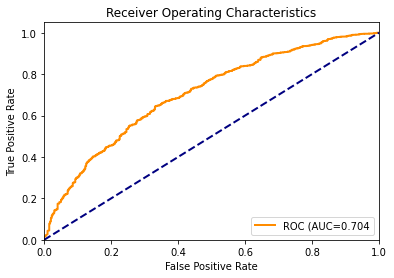

In [243]:
# Inspiration taken directly from SkLearn website:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html#sklearn.model_selection.RandomizedSearchCV

# Import model
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from scipy.stats import randint
from src.utils.misc import get_list_proportions

# Instantiate
cla = XGBClassifier \
    ( n_jobs=4
    , random_state=123
    )

# Define hyperparameters
params = dict \
    ( n_estimators=randint(low=50, high=500)
    , learning_rate=[0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001]
    , max_depth=randint(low=1, high=200)#[5,10,20,50,75,100,200]
    , subsample=uniform(loc=0, scale=1)
    , colsample_bytree=uniform(loc=0, scale=1)
    , gamma=uniform(loc=0, scale=1)
    , reg_alpha=uniform(loc=0, scale=1)
    , reg_lambda=uniform(loc=0, scale=1)
    )

# Re-instantiate
clf = RandomizedSearchCV \
    ( estimator=cla
    , param_distributions=params
    , n_iter=100
    , scoring={"auc": make_scorer(roc_auc_score, needs_proba=True)}
    , cv=5
    , refit="auc"
    , random_state=123
    , return_train_score=True
    )

# Search for results
t.tic()
res = clf.fit(feat_trn, targ_trn, eval_metric="auc")
t.toc()

# Check best params
print(res.best_params_)

# Redefine
cla = cla.set_params(**res.best_params_)

# Refit
cla.fit(feat_trn, targ_trn, eval_metric="auc")

# Predict
pred_trn = cla.predict(feat_trn)
pred_prob_trn = cla.predict_proba(feat_trn)
pred_val = cla.predict(feat_val)
pred_prob_val = cla.predict_proba(feat_val)

# Check performance
save_reg_perf(targ_trn, pred_trn, pred_prob_trn, "XGBoost - RandomSearch - within bag", print_all=False)
save_reg_perf(targ_val, pred_val, pred_prob_val, "XGBoost - RandomSearch - out of bag")

# Backup
dump(cla, "./models/Chris/14_XGBoost_RandomSearch.joblib")

In [244]:
pred_scor

,name,when,auc,sens,spec,f1
0,Raw baseline,13/Feb 10:40,0.50000,1.00000,0.00000,0.90926
1,LogisticRegression - Defaults,13/Feb 10:40,0.70163,0.99350,0.05514,0.91067
2,LogisticRegressionCV - Defaults,13/Feb 10:40,0.70830,0.99430,0.03757,0.90954
3,RidgeClassifier - Defaults,13/Feb 10:40,0.69848,0.99850,0.00501,0.90901
4,RidgeClassifierCV - Defaults,13/Feb 10:40,0.70651,0.99970,0.00376,0.90943
5,SGDClassifier - Defaults,13/Feb 10:40,0.68176,0.99650,0.02506,0.90967
6,RandomForest - Defaults,13/Feb 10:40,0.68110,0.97651,0.07769,0.90400
7,Bagging - Defaults,13/Feb 10:40,0.63222,0.92954,0.14035,0.88487
8,Boosting - Defaults,13/Feb 10:40,0.69825,0.98851,0.05263,0.90796
9,AdaBoost - Defaults,13/Feb 10:40,0.68613,0.99200,0.02256,0.90722


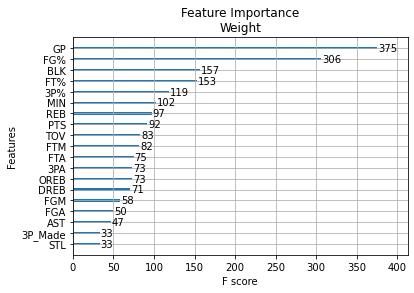

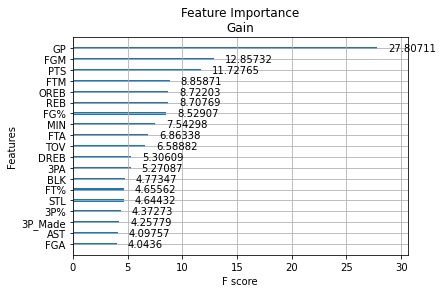

In [274]:
# Define mapper
mapp = {"f{0}".format(i): v for i, v in enumerate(data.columns)}

# Loop different types of importance
for typ in ["weight","gain"]:
    feat_imp = {mapp[k]: round(v,5) for k, v in cla.get_booster().get_score(importance_type=typ).items()}
    xgb.plot_importance(feat_imp, title="Feature Importance\n"+typ.title())

### Attempt 15: XGBoost with Random Search and Feature Engineering

In [277]:
# Check which variables are most important from RandomForest experiment
impt = {data.columns[indx]:valu for indx,valu in enumerate(cla.feature_importances_)}
impt = pd.DataFrame({"name":impt.keys(), "valu":impt.values()})
impt["desc"] = impt["name"].map(lambda name: DataDict[name])
impt = impt[["name","desc","valu"]]
display(impt.sort_values("valu", ascending=False))

,name,desc,valu
0,GP,Games Played,0.185843
3,FGM,Field Goals Made,0.085929
2,PTS,Points Per Game,0.078379
9,FTM,Free Throw Made,0.059205
12,OREB,Offensive Rebounds,0.058292
14,REB,Rebounds,0.058196
5,FG%,Field Goals Percent,0.057002
1,MIN,Minutes Played,0.050412
10,FTA,Free Throw Attempts,0.045870
18,TOV,Turnovers,0.044035


In [324]:
# !THEORY! The columns with the percentages are throwing off the overall performance

# Inspect columns to see which ones to keep
display(impt)

# Define cols to use WITH percentages
# Remove columns with 'Made' and 'Attempt' in the description
# Also remove the 4 lowest performing columns: `FGA`,`AST`,`3P_Made`,`STL`
pcts = [0,1,2,5,8,11,12,13,14,17,18]

# Define cols to use WITHOUT percentages
# Remove columns with 'Percent' in the description
# Also remove the 4 lowest performing columns: `FGA`,`AST`,`3P_Made`,`STL`
non_pcts = [0,1,2,3,7,9,10,12,13,14,17,18]

,name,desc,valu
0,GP,Games Played,0.185843
1,MIN,Minutes Played,0.050412
2,PTS,Points Per Game,0.078379
3,FGM,Field Goals Made,0.085929
4,FGA,Field Goals Attempts,0.027025
5,FG%,Field Goals Percent,0.057002
6,3P_Made,3-Points Made,0.028456
7,3PA,3-Points Attempts,0.035227
8,3P%,3-Points Percent,0.029224
9,FTM,Free Throw Made,0.059205


In [291]:
# Define hyperparameters
params = dict \
    ( n_estimators=randint(low=50, high=500)
    , learning_rate=[0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001]
    , max_depth=randint(low=1, high=200)
    , subsample=uniform(loc=0, scale=1)
    , colsample_bytree=uniform(loc=0, scale=1)
    , gamma=uniform(loc=0, scale=1)
    , reg_alpha=uniform(loc=0, scale=1)
    , reg_lambda=uniform(loc=0, scale=1)
    )

Elapsed time: 0:07:23
Best score: 0.6934866835784483
Best params: {'colsample_bytree': 0.9874783222814236, 'gamma': 0.3494149296248078, 'learning_rate': 0.0001, 'max_depth': 4, 'n_estimators': 149, 'reg_alpha': 0.42834727470094924, 'reg_lambda': 0.2045428595464277, 'subsample': 0.4506364905187348}


pred      
          0     1
targ 0    4   395
     1    4  1997

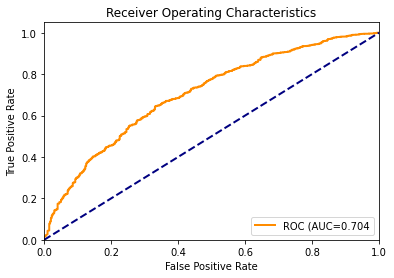

In [315]:
# Re-Instantiate
cla = XGBClassifier \
    ( n_jobs=4
    , random_state=123
    )
    
# Get baseline of full data set
cla = easy_random_search \
    ( estimator=cla
    , search_space=params
    , feat_trn=feat_trn
    , targ_trn=targ_trn
    , feat_val=feat_val
    , targ_val=targ_val
    , n_iter=100
    , cv=5
    , random_state=123
    , check_best_params=True
    , dump_model=False
    , print_all=True
    , print_dataframe=False
    )

Elapsed time: 0:05:56
Best score: 0.6956584797727918
Best params: {'colsample_bytree': 0.9874783222814236, 'gamma': 0.3494149296248078, 'learning_rate': 0.0001, 'max_depth': 4, 'n_estimators': 149, 'reg_alpha': 0.42834727470094924, 'reg_lambda': 0.2045428595464277, 'subsample': 0.4506364905187348}


pred      
          0     1
targ 0    3   396
     1    5  1996

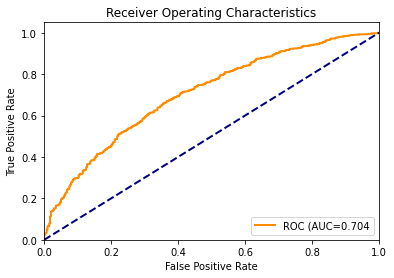

In [319]:
# Re-Instantiate
cla = XGBClassifier \
    ( n_jobs=4
    , random_state=123
    )
    
# Test random search ONLY USING averages
cla = easy_random_search \
    ( estimator=cla
    , search_space=params
    , feat_trn=feat_trn[:,pcts]
    , targ_trn=targ_trn
    , feat_val=feat_val[:,pcts]
    , targ_val=targ_val
    , n_iter=100
    , cv=5
    , random_state=123
    , check_best_params=True
    , dump_model=False
    , print_all=True
    , print_dataframe=False
    )

Elapsed time: 0:05:53
Best score: 0.6904615816580166
Best params: {'colsample_bytree': 0.9874783222814236, 'gamma': 0.3494149296248078, 'learning_rate': 0.0001, 'max_depth': 4, 'n_estimators': 149, 'reg_alpha': 0.42834727470094924, 'reg_lambda': 0.2045428595464277, 'subsample': 0.4506364905187348}


pred      
          0     1
targ 0    8   391
     1    3  1998

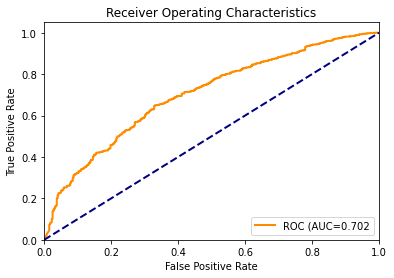

In [317]:
# Re-Instantiate
cla = XGBClassifier \
    ( n_jobs=4
    , random_state=123
    )
    
# Test random search WITHOUT USING averages
cla = easy_random_search \
    ( estimator=cla
    , search_space=params
    , feat_trn=feat_trn[:,non_pcts]
    , targ_trn=targ_trn
    , feat_val=feat_val[:,non_pcts]
    , targ_val=targ_val
    , n_iter=100
    , cv=5
    , random_state=123
    , check_best_params=True
    , dump_model=False
    , print_all=True
    , print_dataframe=False
    )

Elapsed time: 0:06:44
Best score: 0.6956584797727918
Best params: {'colsample_bytree': 0.9874783222814236, 'gamma': 0.3494149296248078, 'learning_rate': 0.0001, 'max_depth': 4, 'n_estimators': 149, 'reg_alpha': 0.42834727470094924, 'reg_lambda': 0.2045428595464277, 'subsample': 0.4506364905187348}


pred      
          0     1
targ 0    3   396
     1    5  1996

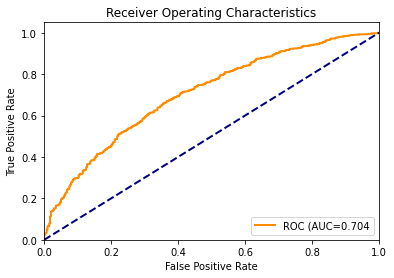

In [320]:
# Choose final model to run again

# Re-Instantiate
cla = XGBClassifier \
    ( n_jobs=4
    , random_state=123
    )
    
# Test random search ONLY USING averages
cla = easy_random_search \
    ( estimator=cla
    , search_space=params
    , feat_trn=feat_trn[:,pcts]
    , targ_trn=targ_trn
    , feat_val=feat_val[:,pcts]
    , targ_val=targ_val
    , n_iter=100
    , cv=5
    , random_state=123
    , check_best_params=True
    , dump_model=True
    , dump_name="15_XGBoost_RandomSearch_FeatureSelection"
    , print_all=True
    , print_dataframe=False
    )

In [321]:
pred_scor

,name,when,auc,sens,spec,f1
0,Raw baseline,13/Feb 10:40,0.50000,1.00000,0.00000,0.90926
1,LogisticRegression - Defaults,13/Feb 10:40,0.70163,0.99350,0.05514,0.91067
2,LogisticRegressionCV - Defaults,13/Feb 10:40,0.70830,0.99430,0.03757,0.90954
3,RidgeClassifier - Defaults,13/Feb 10:40,0.69848,0.99850,0.00501,0.90901
4,RidgeClassifierCV - Defaults,13/Feb 10:40,0.70651,0.99970,0.00376,0.90943
5,SGDClassifier - Defaults,13/Feb 10:40,0.68176,0.99650,0.02506,0.90967
6,RandomForest - Defaults,13/Feb 10:40,0.68110,0.97651,0.07769,0.90400
7,Bagging - Defaults,13/Feb 10:40,0.63222,0.92954,0.14035,0.88487
8,Boosting - Defaults,13/Feb 10:40,0.69825,0.98851,0.05263,0.90796
9,AdaBoost - Defaults,13/Feb 10:40,0.68613,0.99200,0.02256,0.90722


## Final Processing & Submitting

### Define final processing steps

In [331]:
isinstance(None, type(None))

True

In [332]:
def final_prediction_processing \
    ( final_model_path:str
    , data_scaler_path:str
    , test_data_path:str="./data/raw/test.csv"
    , test_col_indices=None
    , submission_data_path:str="./data/external/final.csv"
    , check:bool=False
    ):
    """
    Process the data for the final prediction.
    Note, this will update the prediction and save it to the `submission_data_path` location.

    Args:
        final_model_path (str): The location from which the final model should be drawn from. Note, this model should be saved as a `` file type, and once imported, should be a sklearn model class.
        data_scaler_path (str): The location from which the data scaler should be imported from. Note, this should be a sklearn preprocessing class
        test_data_path (str, optional): The location from which the test data should be imported. Note, it should be a `.csv` file type. Defaults to "./data/raw/test.csv".
        submission_data_path (str, optional): The location to which the final submission data should be stored. Note, it should be a `.csv` file type. Defaults to "./data/external/final.csv".
        check (bool, optional): Optional flag for wheather or not to `display()` the final data frame, mainly for checking purposes. Defaults to False.

    Returns:
        pd.DataFrame: The updated `submission_data` dataframe
    """

    # Imports
    import numpy as np
    import pandas as pd
    from src.utils.misc import str_right

    # Assertions
    for parameter in [final_model_path, data_scaler_path, test_data_path, submission_data_path]:
        assert np.isscalar(parameter)
        assert isinstance(parameter, str)
        if parameter in [final_model_path, data_scaler_path]:
            assert str_right(parameter, 7) == ".joblib"
        if parameter in [test_data_path, submission_data_path]:
            assert str_right(parameter, 4) == ".csv"
    assert isinstance(check, bool)
    assert isinstance(test_col_indices, (type(None), list))
    if isinstance(test_col_indices, list):
        assert np.all([isinstance(i, int) for i in test_col_indices])
    
    # Import selected data
    final_model = load(final_model_path)
    data_scaler = load(data_scaler_path)
    test_data = pd.read_csv(test_data_path)

    # Process final data
    submission_data = test_data.pop('Id')
    test_data = test_data.drop(['Id_old'], axis=1)
    test_data = data_scaler.fit_transform(test_data)
    if not test_col_indices is None:
        test_data = test_data[:, test_col_indices]

    # Get prediction
    final_prediction = final_model.predict_proba(test_data)

    # Form final data
    submission_data = pd.concat([pd.DataFrame(submission_data), pd.DataFrame(final_prediction[:,1])], axis=1)
    submission_data.columns = ["Id", "TARGET_5Yrs"]
    # submission_data["TARGET_5Yrs"] = submission_data["TARGET_5Yrs"].apply(lambda pred: 1 if pred > 0.5 else 0)

    # Check
    if check:
        display(submission_data)

    # Save to file
    submission_data.to_csv(submission_data_path, index=False)

    return submission_data

In [333]:
# Process the final data
submission_data = final_prediction_processing \
    ( final_model_path = "./models/Chris/15_XGBoost_RandomSearch_FeatureSelection.joblib"
    , data_scaler_path = "./models/Chris/scaler.joblib"
    , test_data_path = "./data/raw/test.csv"
    , test_col_indices = pcts
    , submission_data_path = "./data/external/final.csv"
    , check = True
    )

,Id,TARGET_5Yrs
0,0,0.504316
1,1,0.504441
2,2,0.506493
3,3,0.506498
4,4,0.504183
...,...,...
3794,3794,0.506547
3795,3795,0.504704
3796,3796,0.503785
3797,3797,0.506516


### Submit to Kaggle

In [334]:
# Function to call Kaggle API
def call_kaggle_api(upload_file, upload_message):
    """
    Call the Kaggle API to submit a file
    Inspiration: https://unix.stackexchange.com/questions/190495/how-to-execute-a-bash-command-in-a-python-script#answer-579917
    
    Args:
        upload_file (str): The source path where the file will be uploaded _from_.
        upload_message (str): The message that will be sent to Kaggle for this submission.

    Raises:
        Exception: CallProcessError, incase subprocess has a wobbly
        Exception: Exception, for everything else

    Returns:
        str: The confirmation string from the API call
    """

    import subprocess

    bash_call = "kaggle competitions submit --competition uts-advdsi-nba-career-prediction --file {upload_file} --message {upload_message} --quiet".format(upload_file=upload_file, upload_message=upload_message)

    try:        
        result = subprocess.run(bash_call, check=True, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    except subprocess.CalledProcessError as err:
        raise Exception(str(err.stderr.decode("utf-8")))
    except Exception as err:
        raise Exception(err)
    else:
        return result.stdout.decode("utf-8")

In [335]:
# Call the API
if False:
    call_kaggle_api \
        ( upload_file = "./data/external/final.csv"
        , upload_message = "CtrlAltElite_XGBoost_RandomSearch_FeatureSelection"
        )